# End-to-End Example #1

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Data ingestion](#Data-ingestion)
  3. [Data inspection](#Data-inspection)
  4. [Data conversion](#Data-conversion)
3. [Training the K-Means model](#Training-the-K-Means-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
  1. [Import model into hosting](#Import-model-into-hosting)
  2. [Create endpoint configuration](#Create-endpoint-configuration)
  3. [Create endpoint](#Create-endpoint)
5. [Validate the model for use](#Validate-the-model-for-use)


## Introduction

Welcome to our first end-to-end example! Today, we're working through a classification problem, specifically of images of handwritten digits, from zero to nine. Let's imagine that this dataset doesn't have labels, so we don't know for sure what the true answer is. In later examples, we'll show the value of "ground truth", as it's commonly known.

Today, however, we need to get these digits classified without ground truth. A common method for doing this is a set of methods known as "clustering", and in particular, the method that we'll look at today is called k-means clustering. In this method, each point belongs to the cluster with the closest mean, and the data is partitioned into a number of clusters that is specified when framing the problem. In this case, since we know there are 10 clusters, and we have no labeled data (in the way we framed the problem), this is a good fit.

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are two parts to this:

1. The role(s) used to give learning and hosting access to your data. See the documentation for how to specify these.
1. The S3 bucket name that you want to use for training and model data. Here we use a default in the form of `sagemaker-{region}-{AWS account ID}`, but you may specify a different one if you wish.

In [1]:
from sagemaker import get_execution_role
from sagemaker.session import Session

role = get_execution_role()
bucket = Session().default_bucket()

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-460207325220


### Data ingestion

Next, we read the dataset from the existing repository into memory, for preprocessing prior to training.  In this case we'll use the MNIST dataset, which contains 70K 28 x 28 pixel images of handwritten digits.  For more details, please see [here](http://yann.lecun.com/exdb/mnist/).

This processing could be done *in situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.

In [2]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 888 ms, sys: 284 ms, total: 1.17 s
Wall time: 3.08 s


### Data inspection

Once the dataset is imported, it's typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed. You can perform those tasks right here in the notebook. As an example, let's go ahead and look at one of the digits that is part of the dataset.

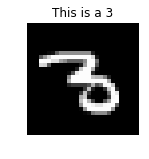

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

### Data conversion and upload

Since algorithms have particular input and output requirements, converting the dataset is also part of the process that a data scientist goes through prior to initiating training. In this particular case, the hosted implementation of k-means takes recordIO-wrapped protobuf, where the data we have right now is a pickle-ized numpy array on disk.

To make this process easier, we'll use a function from the Amazon SageMaker Python SDK.  For this dataset, conversion can take up to one minute.

In [4]:
%%time
from sagemaker.amazon.common import write_numpy_to_dense_tensor
import io
import boto3

data_key = 'kmeans_lowlevel_example/data'
data_location = 's3://{}/{}'.format(bucket, data_key)
print('training data will be uploaded to: {}'.format(data_location))

# Convert the training data into the format required by the SageMaker KMeans algorithm
buf = io.BytesIO()
write_numpy_to_dense_tensor(buf, train_set[0], train_set[1])
buf.seek(0)

boto3.resource('s3').Bucket(bucket).Object(data_key).upload_fileobj(buf)

training data will be uploaded to: s3://sagemaker-us-east-1-460207325220/kmeans_lowlevel_example/data
CPU times: user 8.72 s, sys: 453 ms, total: 9.18 s
Wall time: 9.39 s


## Training the K-Means model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. Since this data is relatively small, it isn't meant to show off the performance of the k-means training algorithm.  But Amazon SageMaker's k-means has been tested on, and scales well with, multi-terabyte datasets.

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between 7 and 11 minutes.

In [ ]:
%%time
import boto3
from time import gmtime, strftime

job_name = 'kmeans-lowlevel-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Training job", job_name)

from sagemaker.amazon.amazon_estimator import get_image_uri
image = get_image_uri(boto3.Session().region_name, 'kmeans')

output_location = 's3://{}/kmeans_example/output'.format(bucket)
print('training artifacts will be uploaded to: {}'.format(output_location))

create_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": output_location
    },
    "ResourceConfig": {
        "InstanceCount": 2,
        "InstanceType": "ml.c4.8xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "k": "10",
        "feature_dim": "784",
        "mini_batch_size": "500",
        "force_dense": "True"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": data_location,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }
    ]
}


sagemaker = boto3.client('sagemaker')

sagemaker.create_training_job(**create_training_params)

status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)

try:
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
finally:
    status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print("Training job ended with status: " + status)
    if status == 'Failed':
        message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Training job failed')


## Set up hosting for the model
In order to set up hosting, we have to import the model from training to hosting. A common question would be, why wouldn't we automatically go from training to hosting?  And, in fact, the [k-means high-level example](/notebooks/sagemaker-python-sdk/1P_kmeans_highlevel/kmeans_mnist.ipynb) shows the functionality to do that.  For this low-level example though it makes sense to show each step in the process to provide a better understanding of the flexibility available.

### Import model into hosting
Next, you register the model with hosting. This allows you the flexibility of importing models trained elsewhere, as well as the choice of not importing models if the target of model creation is AWS Lambda, AWS Greengrass, Amazon Redshift, Amazon Athena, or other deployment target.

In [ ]:
%%time
import boto3
from time import gmtime, strftime


model_name=job_name
print(model_name)

info = sagemaker.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']

primary_container = {
    'Image': image,
    'ModelDataUrl': model_data
}

create_model_response = sagemaker.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

### Create endpoint configuration
Now, we'll create an endpoint configuration which provides the instance type and count for model deployment.

In [ ]:
from time import gmtime, strftime

endpoint_config_name = 'KMeansEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sagemaker.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

### Create endpoint
Lastly, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.

In [ ]:
%%time
import time

endpoint_name = 'KMeansEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sagemaker.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

try:
    sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
finally:
    resp = sagemaker.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Arn: " + resp['EndpointArn'])
    print("Create endpoint ended with status: " + status)

    if status != 'InService':
        message = sagemaker.describe_endpoint(EndpointName=endpoint_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Endpoint creation did not succeed')


## Validate the model for use
Finally, we'll validate the model for use. Let's generate a classification for a single observation from the trained model using the endpoint we just created.

In [ ]:
# Simple function to create a csv from our numpy array
def np2csv(arr):
    csv = io.BytesIO()
    numpy.savetxt(csv, arr, delimiter=',', fmt='%g')
    return csv.getvalue().decode().rstrip()

In [ ]:
runtime = boto3.Session().client('runtime.sagemaker')

In [ ]:
import json

payload = np2csv(train_set[0][30:31])

response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/csv', 
                                   Body=payload)
result = json.loads(response['Body'].read().decode())
print(result)

OK, a single prediction works.

Let's do a whole batch and see how well the clustering works.

In [ ]:
%%time 

payload = np2csv(valid_set[0][0:100])
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/csv', 
                                   Body=payload)
result = json.loads(response['Body'].read().decode())
clusters = [p['closest_cluster'] for p in result['predictions']]

for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ]
    height=((len(digits)-1)//5)+1
    width=5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots=numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()


### The bottom line

K-Means clustering is not the best algorithm for image analysis problems, but we do see pretty reasonable clusters being built.

### Clean up

If you're ready to be done with this notebook, make sure run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
sagemaker.delete_endpoint(EndpointName=endpoint_name)